In [ ]:
!date

# NY Inventory Flow Forecasting

In this notebook, we tried to predict the inbound & outbound traffic from the warehouse, in order to help allocate workforce. Noted that the max capacity of the warehouse is 3500 orders/day as of July 2019, but our predictions are not limited by that. 

There are six types of warehouse activities: 
1. Outbound customer order
2. Outbound items transfer
3. Outbound purchase order return
4. Inbound customer return
5. Inbound items transfer
6. Inbound purchase order

### Imports and settings 

In [1]:
import pandas as pd
import numpy as np
import queries.utils as utils
from matplotlib import pyplot as plt


#### fbprophet 
import fbprophet
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
from fbprophet.plot import plot_cross_validation_metric

pd.plotting.register_matplotlib_converters() ## bugs.. fbprophet & matplotlib

ERROR:fbprophet:Importing plotly failed. Interactive plots will not work.


### Import Data

In [2]:
#### Read the customer order data
data_raw_all = pd.read_csv('data/inven_est_072319.csv')

In [3]:
data_raw_all.head()

date_est  OUT_CUST_UNITS  OUT_TO_UNITS  OUT_VR_UNITS  IN_CUST_UNITS  \
0  2016-01-01             256             0             0             19   
1  2016-01-02             228             0             0              0   
2  2016-01-03             208             0             0              0   
3  2016-01-04             235             1             0            134   
4  2016-01-05             362            24             0            112   

   IN_PO_UNITS  IN_TO_UNITS  TTL_OUT_UNITS  TTL_IN_UNITS  TTL_ALL_UNITS  
0            0            0            256            19            275  
1            0            0            228             0            228  
2            0            0            208             0            208  
3          264            0            236           398            634  
4          338            0            386           450            836

### Lag Correlation Testing

In [4]:
def df_derived_by_shift(df,lag=0,NON_DER=[]):
    df = df.copy()
    if not lag:
        return df
    cols ={}
    for i in range(1,lag+1):
        for x in list(df.columns):
            if x not in NON_DER:
                if not x in cols:
                    cols[x] = ['{}_{}'.format(x, i)]
                else:
                    cols[x].append('{}_{}'.format(x, i))
    for k,v in cols.items():
        columns = v
        dfn = pd.DataFrame(data=None, columns=columns, index=df.index)    
        i = 1
        for c in columns:
            dfn[c] = df[k].shift(periods=i)
            i+=1
        df = pd.concat([df, dfn], axis=1, join_axes=[df.index])
    return df

In [5]:
cross_data_raw = pd.read_csv('data/PO_EST_ACT_MA.csv')

In [6]:
cross_data_raw.head()

date   IN_PO_EST  IN_PO_UNITS  IN_PO_EST_MA  IN_PO_UNITS_MA  \
0  2016-01-01  199.583221            0    199.583221             0.0   
1  2016-01-02    0.000000            0     99.791610             0.0   
2  2016-01-03    0.000000            0     66.527740             0.0   
3  2016-01-04  198.301175          264     99.471099            66.0   
4  2016-01-05  208.393130          338    121.255505           120.4   

   OUT_CUST_UNITS  TTL_OUT_UNITS  TTL_IN_UNITS  TTL_ALL_UNITS  
0           256.0          256.0          19.0          275.0  
1           228.0          228.0           0.0          228.0  
2           208.0          208.0           0.0          208.0  
3           235.0          236.0         398.0          634.0  
4           362.0          386.0         450.0          836.0

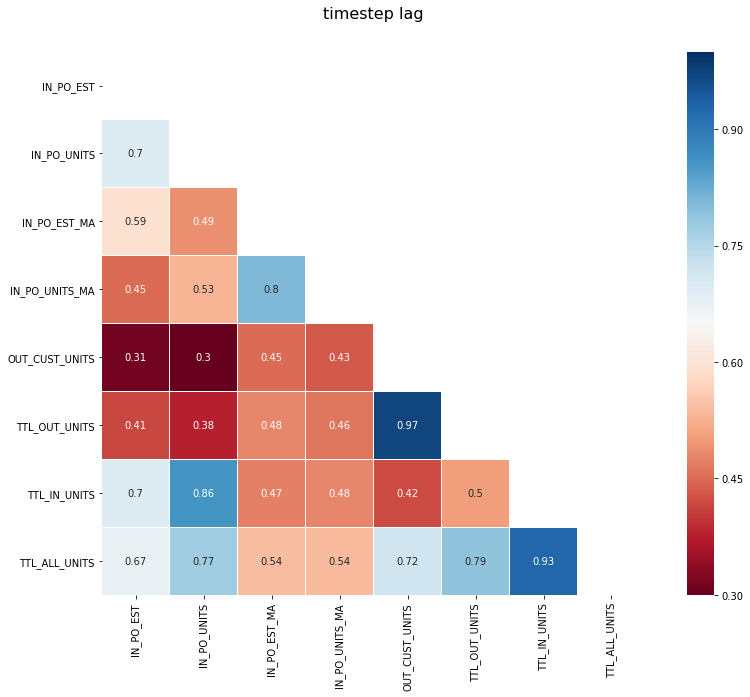

In [7]:
data_matrix = cross_data_raw 
data_matrix = data_matrix[data_matrix['date'] < '2019-07-25']
data_matrix = data_matrix[data_matrix['date'] > '2016-01-07']

NON_DER = ['date',]
df_new = df_derived_by_shift(data_matrix, 0, NON_DER)

import seaborn as sns
colormap = plt.cm.RdBu
plt.figure(figsize=(15,10))
plt.title(u'timestep lag', y=1.05, size=16)

mask = np.zeros_like(df_new.corr())
mask[np.triu_indices_from(mask)] = True

svm = sns.heatmap(df_new.corr(), mask=mask, linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)


In [8]:
cross_corr = cross_data_raw[cross_data_raw['date'] < '2019-07-25']

cross_corr = cross_corr[cross_corr['date'] > '2016-01-07']

#cross_corr = cross_corr[['date','IN_PO_UNITS','IN_PO_EST']]

cross_corr = cross_corr[['date','IN_PO_UNITS','IN_PO_EST','IN_PO_UNITS_MA','IN_PO_EST_MA']]

cross_corr.head(10)

date  IN_PO_UNITS   IN_PO_EST  IN_PO_UNITS_MA  IN_PO_EST_MA
7   2016-01-08          280  210.558077      173.625000    154.021017
8   2016-01-09            0    0.000000      154.333333    136.907571
9   2016-01-10            0    0.000000      138.900000    123.216814
10  2016-01-11          287  215.404871      152.363636    131.597546
11  2016-01-12          135  210.738205      150.916667    138.192601
12  2016-01-13           13  213.355852      140.307692    143.974390
13  2016-01-14          317  213.355852      152.928571    148.930208
14  2016-01-15          290  323.295810      162.066667    160.554582
15  2016-01-16            0    0.000000      162.066667    147.249034
16  2016-01-17            0    0.000000      162.066667    147.249034

In [9]:
cross_corr['IN_PO_UNITS_MA'].fillna(0, inplace=True)

#cross_corr[cross_corr['IN_CUST_UNITS']<30] = 100

#cross_corr['IN_CUST_UNITS'].replace(0, np.nan, inplace=True)


In [10]:
display(cross_corr['IN_PO_UNITS'].size)

print(str(np.mean(np.abs(cross_corr['IN_PO_EST_MA'] - cross_corr['IN_PO_UNITS_MA'])/cross_corr['IN_PO_UNITS_MA'].replace(0, np.nan))))


1294

0.24182745525256893


In [11]:
display(cross_corr.head(5))
display(cross_corr.tail(5))

date  IN_PO_UNITS   IN_PO_EST  IN_PO_UNITS_MA  IN_PO_EST_MA
7   2016-01-08          280  210.558077      173.625000    154.021017
8   2016-01-09            0    0.000000      154.333333    136.907571
9   2016-01-10            0    0.000000      138.900000    123.216814
10  2016-01-11          287  215.404871      152.363636    131.597546
11  2016-01-12          135  210.738205      150.916667    138.192601

date  IN_PO_UNITS    IN_PO_EST  IN_PO_UNITS_MA  IN_PO_EST_MA
1296  2019-07-20         1045     0.000000      920.866667    800.436686
1297  2019-07-21          620     0.000000      962.200000    800.436686
1298  2019-07-22         1476  1224.096804     1026.133333    882.043140
1299  2019-07-23          958  1216.943948     1023.933333    886.362246
1300  2019-07-24          992  1217.401090     1033.800000    892.223563

In [ ]:
#cross_corr['IN_PO_UNITS'] = cross_corr['IN_PO_UNITS'].interpolate(method='linear')
#cross_corr['IN_PO_EST'] = cross_corr['IN_PO_EST'].interpolate(method='linear')

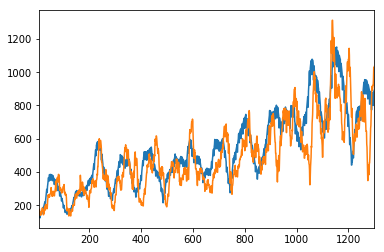

In [12]:
cross_corr['IN_PO_EST_MA'].plot()
cross_corr['IN_PO_UNITS_MA'].plot()

In [ ]:
#cross_data_raw['IN_CUST_UNITS'].plot()

In [ ]:
#df_new.head(5)

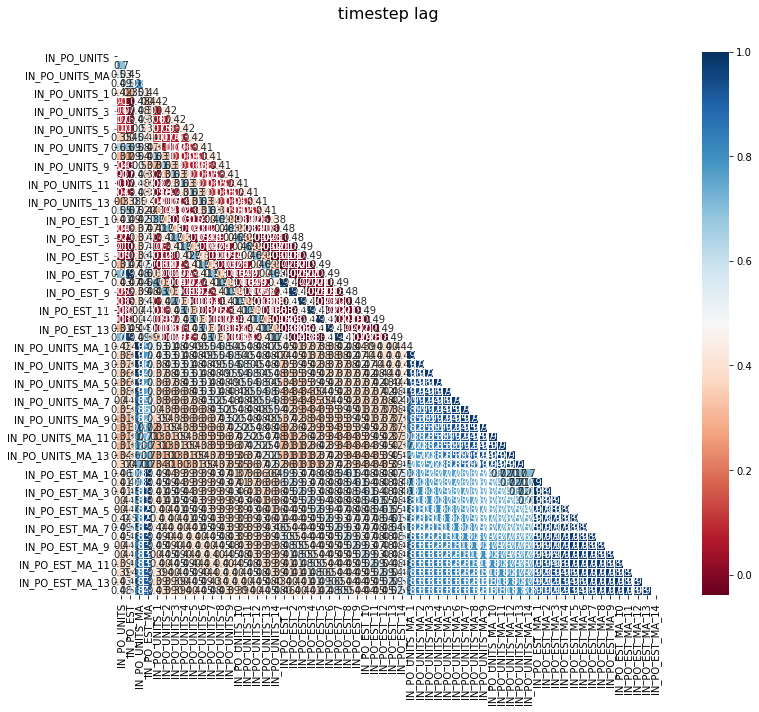

In [13]:
NON_DER = ['date',]
df_new = df_derived_by_shift(cross_corr, 14, NON_DER)

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
colormap = plt.cm.RdBu
plt.figure(figsize=(15,10))
plt.title(u'timestep lag', y=1.05, size=16)

mask = np.zeros_like(df_new.corr())
mask[np.triu_indices_from(mask)] = True

svm = sns.heatmap(df_new.corr(), mask=mask, linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)

In [ ]:
df_new.corr()

### Model Data Ingestion

In [14]:
dat = data_raw_all[['date_est','IN_PO_UNITS']]

# dat = cross_data_raw[['date','IN_PO_UNITS_MA']]
# dat = dat[dat['date'] < '2019-07-25']

display(dat.head())
display(dat.tail())
display(dat.size)

date_est  IN_PO_UNITS
0  2016-01-01            0
1  2016-01-02            0
2  2016-01-03            0
3  2016-01-04          264
4  2016-01-05          338

date_est  IN_PO_UNITS
1298  2019-07-22         1474
1299  2019-07-23          958
1300  2019-07-24          992
1301  2019-07-25         1490
1302  2019-07-26          881

2606

In [ ]:
# dat.index = pd.to_datetime(dat.date_est)
# dat.drop(["date_est"],axis=1,inplace=True)
# dat.index = dat.index.rename("ds")

In [15]:
dat = dat.rename(columns={'date_est':'ds','IN_PO_UNITS':'y'})

# dat = dat.rename(columns={'date':'ds','IN_PO_UNITS_MA':'y'})

dat.head()

ds    y
0  2016-01-01    0
1  2016-01-02    0
2  2016-01-03    0
3  2016-01-04  264
4  2016-01-05  338

In [ ]:
# #### Read the customer order data from gbq (update real time)
# from google.cloud import bigquery as bq
# client = bq.Client()
# with open( 'queries/customer_orders_query.sql') as f:
#     q_customer_orders = f.read()
# dat_realtime = client.query(q_customer_orders).to_dataframe()
# dat_realtime.tail()

In [16]:
dat_curr_prediction = pd.read_csv('data/inven_curr_predictions.csv')
dat_curr_prediction.head()

FCST_Dt  FCT_IN_PO  FCT_IN_Return  FCT_IN_TO  FCT_IN_TOTAL  FCT_OUT_Ord  \
0  2019-05-19       0.00           0.00        0.0          0.00      2144.79   
1  2019-05-20    1039.73          53.77      118.0       1211.50      1884.79   
2  2019-05-21     586.73          53.77      118.0        758.50      2088.79   
3  2019-05-22     506.73         115.67      118.0        740.39      1868.79   
4  2019-05-23     619.73         570.71      118.0       1308.44      1696.51   

   FCT_OUT_TO  FCT_OUT_TOTAL  FCT_TOTAL  
0         0.0        2144.79    2144.79  
1       351.0        2235.79    3447.28  
2       351.0        2439.79    3198.28  
3       351.0        2219.79    2960.18  
4       351.0        2047.51    3355.95

In [17]:
#### Read the current prediction data from the forecast team

dat_curr_prediction = dat_curr_prediction.loc[:,['FCST_Dt','FCT_IN_PO']]
dat_curr_prediction.rename(columns={'FCST_Dt':'ds','FCT_IN_PO':'IN_PO'},inplace=True)
dat_curr_prediction.index = pd.to_datetime(dat_curr_prediction['ds'])
dat_curr_prediction.drop(["ds"],axis=1,inplace=True)
dat_curr_prediction.tail()

IN_PO
ds                 
2019-12-24  1880.32
2019-12-25  1811.39
2019-12-26  1788.15
2019-12-27  1476.77
2019-12-28     0.00

In [112]:
#### Read holiday/markdown info
holidays = pd.read_csv('data/po_holidays.csv')
holidays.tail()

ds  holiday  lower_window  upper_window  hist_ind
12   6/29/2018  PO BULK           -14            14         1
13   8/21/2018  PO BULK           -14            14         1
14  11/23/2018  PO BULK           -14            14         1
15   2/11/2019  PO BULK           -14            14         1
16    4/5/2019  PO BULK           -14            14         1

## FB Prophet Model

In [113]:
fbprophet.__version__

Prophet = fbprophet.Prophet

### Data Preparation

In [114]:
# Parameters Settings

split_date = '2019-05-19'  # Setting the train test cutoff date
forward_days = 100  # set up how


In [115]:
dat_train = dat.loc[dat.ds<split_date , :]
dat_test = dat.loc[dat.ds>=split_date , :]

In [116]:
dat_all = pd.concat([dat_train,dat_test])
dat_all.shape

(1303, 2)

In [117]:
dat_train.tail()

ds     y
1229  2019-05-14   895
1230  2019-05-15  1027
1231  2019-05-16   904
1232  2019-05-17   470
1233  2019-05-18     0

In [118]:
#dat_train.head()

reg_po_est_full = cross_data_raw[['date','IN_PO_EST']]

reg_po_est_full = reg_po_est_full.rename(columns={'date':'ds','IN_PO_EST':'reg'})


cross_corr[cross_corr['date'] > '2016-01-07']

reg_po_est_train = reg_po_est_full[reg_po_est_full['ds']< '2019-05-19']


In [119]:
reg_po_est_full.tail()

ds         reg
1489  2020-01-29  439.159390
1490  2020-01-30  441.837962
1491  2020-01-31  368.890628
1492  2020-02-01    0.000000
1493  2020-02-02    0.000000

In [120]:
reg_po_est_train.tail()

ds          reg
1229  2019-05-14  1043.609617
1230  2019-05-15  1283.103148
1231  2019-05-16  1076.391430
1232  2019-05-17  1074.752144
1233  2019-05-18     0.000000

### Baseline Model With Holiday / Regressors to Capture the Promotion Event

#### Model set up

In [121]:
m = Prophet(changepoint_prior_scale=0.1, changepoint_range=0.9 ,\
            seasonality_mode='multiplicative', seasonality_prior_scale = 10 ,\
            holidays_prior_scale = 10, \
            yearly_seasonality=True, \
            weekly_seasonality=True, \
            daily_seasonality=False \
           ,holidays = holidays
           )



m_full = Prophet(changepoint_prior_scale=0.1, changepoint_range=0.9 ,\
            seasonality_mode='multiplicative', seasonality_prior_scale = 10 ,\
            holidays_prior_scale = 10, \
            yearly_seasonality=True, \
            weekly_seasonality=True, \
            daily_seasonality=False \
           ,holidays = holidays
           )


# ### Add extra regressors
dat_train['reg'] = reg_po_est_train['reg']
m.add_regressor('reg', prior_scale = 10, mode='multiplicative') 

dat_all['reg'] = reg_po_est_full['reg']
m_full.add_regressor('reg', prior_scale = 10, mode='multiplicative') 


C:\Users\m.young\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [122]:
dat_train.head()
dat_train.tail()

ds     y          reg
1229  2019-05-14   895  1043.609617
1230  2019-05-15  1027  1283.103148
1231  2019-05-16   904  1076.391430
1232  2019-05-17   470  1074.752144
1233  2019-05-18     0     0.000000

In [123]:
m.fit(dat_train)
m_full.fit(dat_all)

C:\Users\m.young\AppData\Local\Continuum\anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):
C:\Users\m.young\AppData\Local\Continuum\anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [124]:
dat_all.tail()

ds     y          reg
1298  2019-07-22  1474  1224.096804
1299  2019-07-23   958  1216.943948
1300  2019-07-24   992  1217.401090
1301  2019-07-25  1490  1293.996231
1302  2019-07-26   881  1297.209054

### Test

In [125]:
# predict forward_days 
future = m.make_future_dataframe(periods=len(dat_test)+forward_days, freq='1D')

future['reg'] = reg_po_est_full['reg']

display(future.head())
display(future.tail())

future = future[future['ds'] < '2020-01-01']


ds         reg
0 2016-01-01  199.583221
1 2016-01-02    0.000000
2 2016-01-03    0.000000
3 2016-01-04  198.301175
4 2016-01-05  208.393130

ds          reg
1398 2019-10-30   975.850771
1399 2019-10-31   800.652994
1400 2019-11-01  1264.714082
1401 2019-11-02     0.000000
1402 2019-11-03     0.000000

In [126]:
forecast = m.predict(future)
forecast.loc[forecast.ds>=split_date,:].tail(10)

ds       trend  yhat_lower   yhat_upper  trend_lower  \
1393 2019-10-25  962.263311  811.636899  1429.075708   954.693702   
1394 2019-10-26  963.100657 -144.950833   471.250663   955.428320   
1395 2019-10-27  963.938002 -447.289328   195.140389   956.123522   
1396 2019-10-28  964.775348  655.366011  1305.754647   956.877146   
1397 2019-10-29  965.612694  688.495701  1328.901131   957.622837   
1398 2019-10-30  966.450040  786.903292  1433.520109   958.374801   
1399 2019-10-31  967.287386  744.486525  1402.158266   959.089576   
1400 2019-11-01  968.124731  775.886689  1416.732168   959.876100   
1401 2019-11-02  968.962077 -188.668846   434.251284   960.636225   
1402 2019-11-03  969.799423 -483.363367   142.308526   961.397780   

      trend_upper  PO BULK  PO BULK_lower  PO BULK_upper  \
1393   969.827784      0.0            0.0            0.0   
1394   970.748696      0.0            0.0            0.0   
1395   971.666376      0.0            0.0            0.0   
1396   972.584056      0.0            0.0            0.0   
1397   973.493880      0.0            0.0            0.0   
1398   974.401603      0.0            0.0            0.0   
1399   975.309325      0.0            0.0            0.0   
1400   976.221974      0.0            0.0            0.0   
1401   977.132390      0.0            0.0            0.0   
1402   977.999309      0.0            0.0            0.0   

      extra_regressors_multiplicative  ...    weekly  weekly_lower  \
1393                         0.018707  ...  0.347861      0.347861   
1394                        -0.024745  ... -0.608711     -0.608711   
1395                        -0.024745  ... -0.887305     -0.887305   
1396                         0.018608  ...  0.218013      0.218013   
1397                         0.018608  ...  0.238554      0.238554   
1398                         0.021777  ...  0.357272      0.357272   
1399                         0.013425  ...  0.334316      0.334316   
1400                         0.035548  ...  0.347861      0.347861   
1401                        -0.024745  ... -0.608711     -0.608711   
1402                        -0.024745  ... -0.887305     -0.887305   

      weekly_upper    yearly  yearly_lower  yearly_upper  additive_terms  \
1393      0.347861 -0.199080     -0.199080     -0.199080             0.0   
1394     -0.608711 -0.203980     -0.203980     -0.203980             0.0   
1395     -0.887305 -0.209726     -0.209726     -0.209726             0.0   
1396      0.218013 -0.216194     -0.216194     -0.216194             0.0   
1397      0.238554 -0.223217     -0.223217     -0.223217             0.0   
1398      0.357272 -0.230593     -0.230593     -0.230593             0.0   
1399      0.334316 -0.238088     -0.238088     -0.238088             0.0   
1400      0.347861 -0.245443     -0.245443     -0.245443             0.0   
1401     -0.608711 -0.252381     -0.252381     -0.252381             0.0   
1402     -0.887305 -0.258613     -0.258613     -0.258613             0.0   

      additive_terms_lower  additive_terms_upper         yhat  
1393                   0.0                   0.0  1123.429819  
1394                   0.0                   0.0   156.564232  
1395                   0.0                   0.0  -117.384804  
1396                   0.0                   0.0   984.483174  
1397                   0.0                   0.0   998.390962  
1398                   0.0                   0.0  1109.925077  
1399                   0.0                   0.0  1073.353407  
1400                   0.0                   0.0  1101.692710  
1401                   0.0                   0.0   110.618861  
1402                   0.0                   0.0  -165.509089  

[10 rows x 31 columns]

### Validation

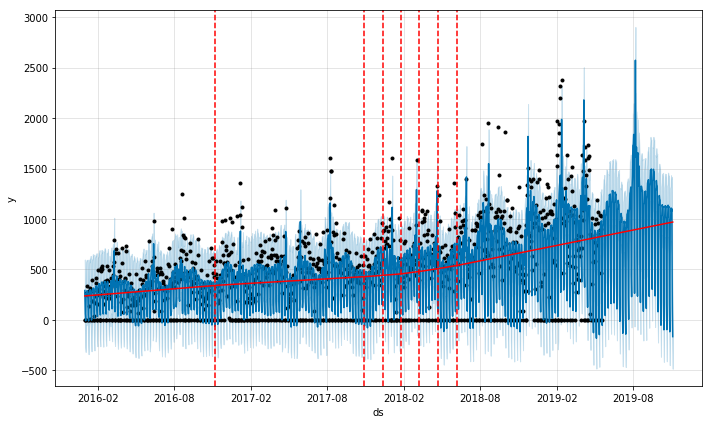

In [127]:
from fbprophet.plot import add_changepoints_to_plot
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)

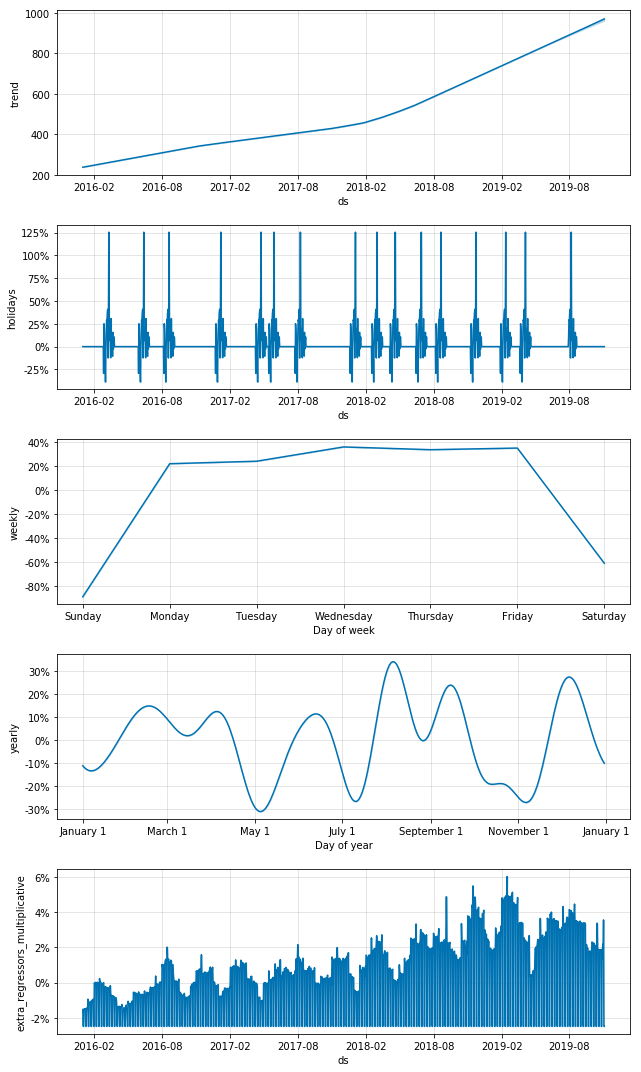

In [128]:
f = m.plot_components(forecast)

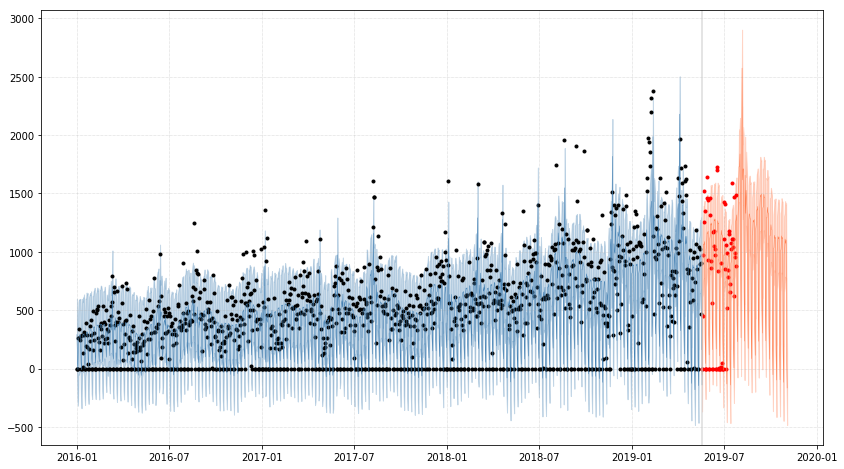

In [157]:
verif = utils.make_verif(forecast, dat_train, dat_test)
f = utils.plot_verif(verif,date=split_date)

In [155]:
verif.head()

ds       trend  yhat_lower  yhat_upper  trend_lower  \
ds                                                                       
2016-01-01 2016-01-01  237.643075   -8.503427  598.715674   237.643075   
2016-01-02 2016-01-02  237.979825 -270.759956  373.300005   237.979825   
2016-01-03 2016-01-03  238.316575 -316.990815  332.981779   238.316575   
2016-01-04 2016-01-04  238.653325  -47.462840  573.633209   238.653325   
2016-01-05 2016-01-05  238.990074  -52.513829  593.029585   238.990074   

            trend_upper  PO BULK  PO BULK_lower  PO BULK_upper  \
ds                                                               
2016-01-01   237.643075      0.0            0.0            0.0   
2016-01-02   237.979825      0.0            0.0            0.0   
2016-01-03   238.316575      0.0            0.0            0.0   
2016-01-04   238.653325      0.0            0.0            0.0   
2016-01-05   238.990074      0.0            0.0            0.0   

            extra_regressors_multiplicative  ...  weekly_lower  weekly_upper  \
ds                                           ...                               
2016-01-01                        -0.015231  ...      0.347861      0.347861   
2016-01-02                        -0.024745  ...     -0.608711     -0.608711   
2016-01-03                        -0.024745  ...     -0.887305     -0.887305   
2016-01-04                        -0.015292  ...      0.218013      0.218013   
2016-01-05                        -0.014811  ...      0.238554      0.238554   

              yearly  yearly_lower  yearly_upper  additive_terms  \
ds                                                                 
2016-01-01 -0.104828     -0.104828     -0.104828             0.0   
2016-01-02 -0.112992     -0.112992     -0.112992             0.0   
2016-01-03 -0.119726     -0.119726     -0.119726             0.0   
2016-01-04 -0.125060     -0.125060     -0.125060             0.0   
2016-01-05 -0.129036     -0.129036     -0.129036             0.0   

            additive_terms_lower  additive_terms_upper        yhat      y  
ds                                                                         
2016-01-01                   0.0                   0.0  291.778734    0.0  
2016-01-02                   0.0                   0.0   60.340073    0.0  
2016-01-03                   0.0                   0.0   -7.572671    0.0  
2016-01-04                   0.0                   0.0  257.187529  264.0  
2016-01-05                   0.0                   0.0  261.624332  338.0  

[5 rows x 32 columns]

In [188]:
# if weekend then make it 0
verif['weekend'] = ((pd.DatetimeIndex(verif.index).dayofweek) // 5 == 1).astype(float)

verif.loc[verif['weekend'] > 0.0, 'yhat'] = 0

In [158]:
# if negative then make it 0
verif.loc[verif['yhat'] < 0.0, 'yhat'] = 0

ds
2019-10-05     224.896979
2019-10-06       0.000000
2019-10-07    1027.011162
2019-10-08    1036.077786
2019-10-09    1141.441644
2019-10-10    1114.750423
2019-10-11    1124.007153
2019-10-12     168.708716
2019-10-13       0.000000
2019-10-14     997.689278
2019-10-15    1030.707599
2019-10-16    1131.576048
2019-10-17    1111.450380
2019-10-18    1125.929355
2019-10-19     170.279193
2019-10-20       0.000000
2019-10-21    1004.818433
2019-10-22    1024.140334
2019-10-23    1137.084716
2019-10-24    1113.107912
2019-10-25    1123.429819
2019-10-26     156.564232
2019-10-27       0.000000
2019-10-28     984.483174
2019-10-29     998.390962
2019-10-30    1109.925077
2019-10-31    1073.353407
2019-11-01    1101.692710
2019-11-02     110.618861
2019-11-03       0.000000
Name: yhat, dtype: float64

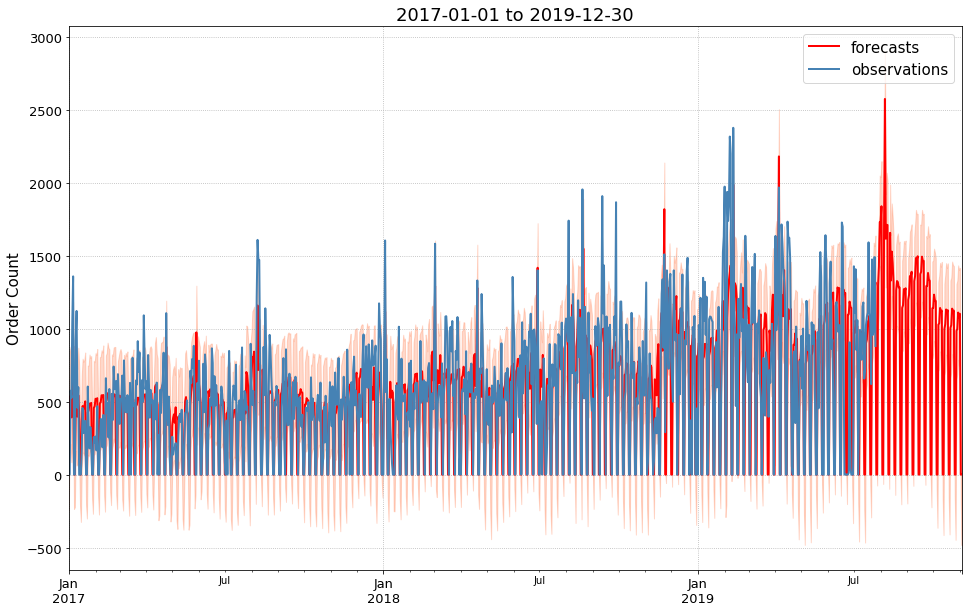

In [192]:
f, ax = plt.subplots(nrows=1, figsize=(16,10), sharey=True)
utils.make_plot_block(verif, '2017-01-01', '2019-12-30', ax=ax)

In [193]:
#verif.tail()

In [ ]:
#f, ax = plt.subplots(nrows=1, figsize=(16,10), sharey=True)
#utils.make_plot_block(verif, '2016-01-01', '2019-12-30', ax=ax)

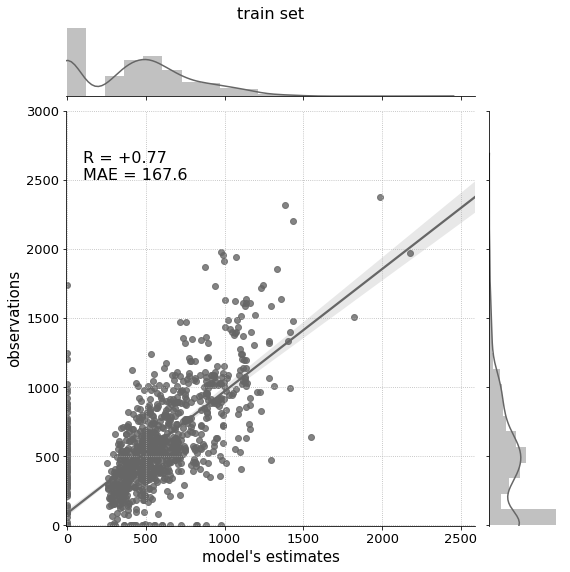

In [194]:
utils.plot_joint_plot(verif.loc[verif.index<split_date,:], title='train set', fname=None)

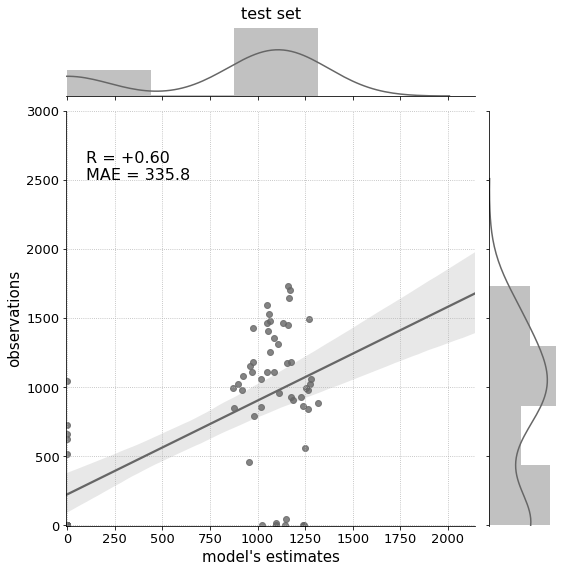

In [195]:
utils.plot_joint_plot(verif.loc[(verif.index>=split_date) &(verif['y'].notnull()) ,:], \
                      title='test set', fname=None)

## Only validate data up until 07/04/2019

In [196]:
m_full.component_modes

{'additive': ['additive_terms', 'extra_regressors_additive'],
 'multiplicative': ['yearly',
  'weekly',
  'PO BULK',
  'reg',
  'multiplicative_terms',
  'extra_regressors_multiplicative',
  'holidays']}

In [197]:
# This is from Prophet
df_cv = cross_validation(m_full, initial='730 days', period='30 days', horizon = '14 days')

INFO:fbprophet:Making 19 forecasts with cutoffs between 2018-01-18 00:00:00 and 2019-07-12 00:00:00
C:\Users\m.young\AppData\Local\Continuum\anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):
C:\Users\m.young\AppData\Local\Continuum\anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):
C:\Users\m.young\AppData\Local\Continuum\anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).typ

In [198]:
df_cv_two_week = cross_validation(m_full, initial='1210 days', period='1 days', horizon = '14 days')

INFO:fbprophet:Making 79 forecasts with cutoffs between 2019-04-25 00:00:00 and 2019-07-12 00:00:00
C:\Users\m.young\AppData\Local\Continuum\anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):
C:\Users\m.young\AppData\Local\Continuum\anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):
C:\Users\m.young\AppData\Local\Continuum\anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).typ

C:\Users\m.young\AppData\Local\Continuum\anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):
C:\Users\m.young\AppData\Local\Continuum\anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):
C:\Users\m.young\AppData\Local\Continuum\anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):
C:\Users\m.young\AppData\Local\Continuum\anaco

C:\Users\m.young\AppData\Local\Continuum\anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):
C:\Users\m.young\AppData\Local\Continuum\anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):
C:\Users\m.young\AppData\Local\Continuum\anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):
C:\Users\m.young\AppData\Local\Continuum\anaco

C:\Users\m.young\AppData\Local\Continuum\anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [199]:
df_cv['horizon'] = df_cv['ds']  - df_cv['cutoff']
df_cv['mape'] = np.abs(df_cv['yhat'] - df_cv['y'])/ df_cv['y']
df_cv = df_cv.loc[df_cv.mape<1,:]
df_p = performance_metrics(df_cv, rolling_window=0.1)
df_p.head()

horizon            mse        rmse         mae      mape  coverage
0  2 days  127869.893836  357.589001  243.546703  0.267358  0.694444
1  3 days   89362.639484  298.935845  209.550950  0.225931  0.726496
2  4 days  141086.668780  375.615054  271.130617  0.265920  0.587302
3  5 days  157652.828280  397.055196  285.903355  0.268960  0.619658
4  6 days  136681.073367  369.704035  306.629342  0.314793  0.531746

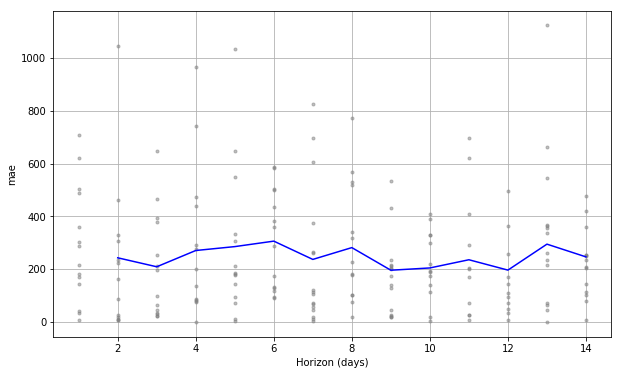

In [200]:
fig = plot_cross_validation_metric(df_cv, metric='mae')

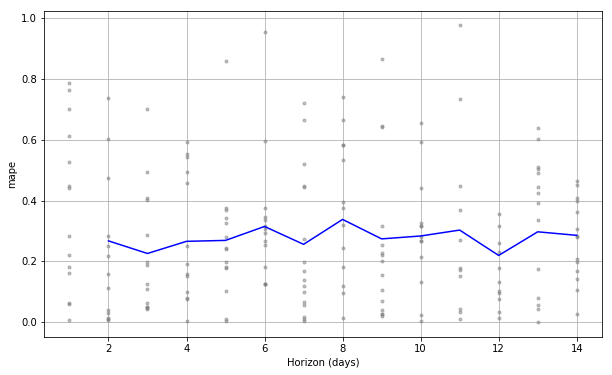

In [201]:
fig = plot_cross_validation_metric(df_cv, metric='mape')

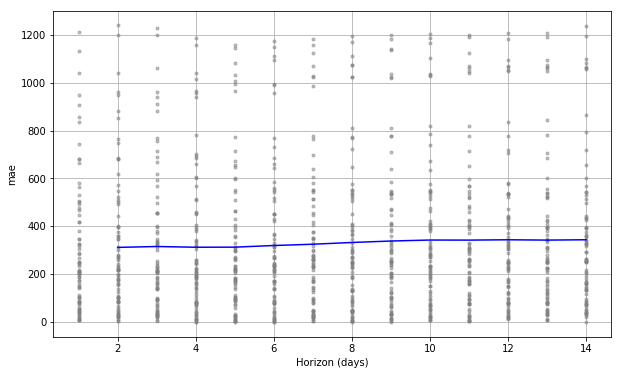

In [202]:
fig = plot_cross_validation_metric(df_cv_two_week, metric='mae')

In [204]:
#fig = plot_cross_validation_metric(df_cv_two_week, metric='mape')

In [205]:
df_cv_two_week['horizon'] = df_cv_two_week['ds']  - df_cv_two_week['cutoff']
df_two_week_prediction = df_cv_two_week.loc[df_cv_two_week.horizon=='14 days',:]
df_two_week_prediction.index = df_two_week_prediction.ds
df_two_week_prediction.drop(columns="ds", inplace=True)

df_1_day_prediction = df_cv_two_week.loc[df_cv_two_week.horizon=='1 days',:]
df_1_day_prediction.index = df_1_day_prediction["ds"]
df_1_day_prediction.drop(columns="ds", inplace=True)

C:\Users\m.young\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [206]:
df_two_week_prediction.head()

yhat  yhat_lower   yhat_upper     y     cutoff horizon
ds                                                                      
2019-05-09  852.389204  526.135888  1178.160066   851 2019-04-25 14 days
2019-05-10  858.594658  553.101351  1178.422957   956 2019-04-26 14 days
2019-05-11   39.363713 -281.253087   337.118722     0 2019-04-27 14 days
2019-05-12 -179.680109 -484.227721   142.541150     0 2019-04-28 14 days
2019-05-13  790.938171  480.983301  1120.559900  1043 2019-04-29 14 days

In [207]:
verif_comp = pd.concat([dat_curr_prediction, verif], axis=1, join='inner').\
filter(items=['yhat_lower','yhat_upper','yhat','y','IN_PO'])
verif_comp = verif_comp.loc[verif_comp['y'].notnull() ,:]
verif_comp.rename(columns ={'y':'Observations' , 'yhat':f'Prophet Model up until {split_date}', 'IN_PO':'Current Excel Model'} ,inplace=True)

verif_comp = verif_comp.merge(right = df_two_week_prediction, on="ds" ,how = "inner", suffixes=('',"_2w"))
verif_comp.rename(columns ={'yhat':'Prophet Model Two Weeks Ahead'} ,inplace=True)

In [211]:
verif_comp.head()

# if weekend then make it 0
verif_comp['weekend'] = ((pd.DatetimeIndex(verif_comp.index).dayofweek) // 5 == 1).astype(float)
verif_comp.loc[verif_comp['weekend'] > 0.0, f'Prophet Model up until {split_date}'] = 0
verif_comp.loc[verif_comp['weekend'] > 0.0, 'Prophet Model Two Weeks Ahead'] = 0

# if negative then make it 0
verif_comp.loc[verif_comp[f'Prophet Model up until {split_date}'] < 0.0, f'Prophet Model up until {split_date}'] = 0
verif_comp.loc[verif_comp['Prophet Model Two Weeks Ahead'] < 0.0, 'Prophet Model Two Weeks Ahead'] = 0

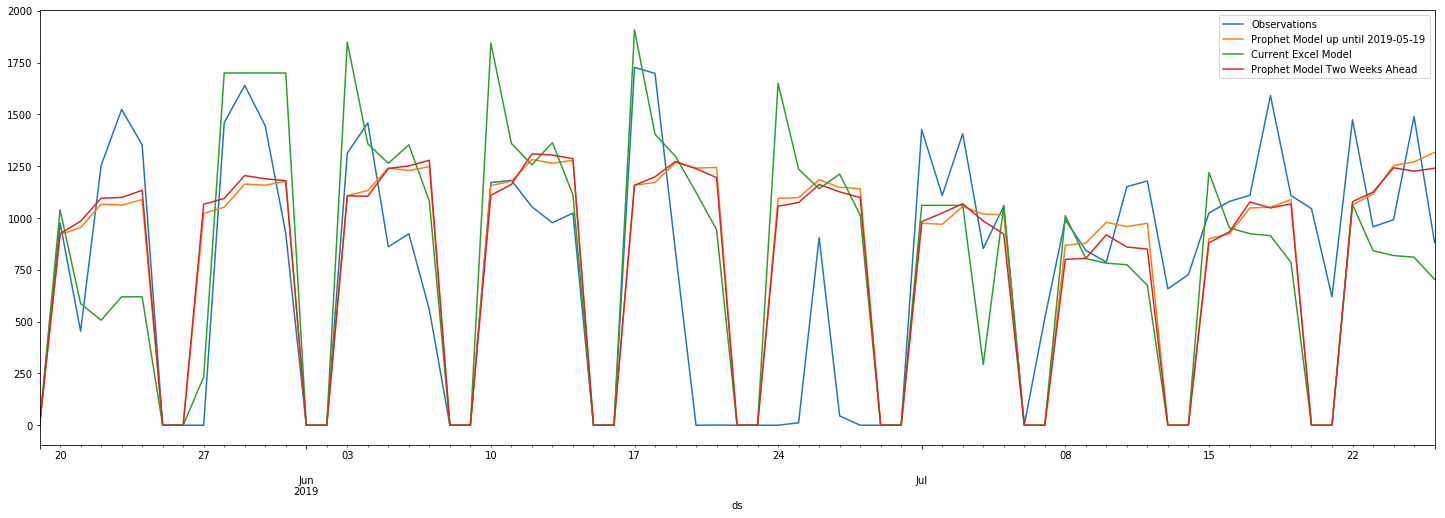

In [212]:
_, ax = plt.subplots(figsize=(25,8))
verif_comp.loc[:,['Observations',f'Prophet Model up until {split_date}'\
                  ,'Current Excel Model','Prophet Model Two Weeks Ahead']].plot(ax=ax)
# ax.fill_between(verif_comp.index, verif_comp.loc[:,'yhat_lower'], verif_comp.loc[:,'yhat_upper'], color='coral', alpha=0.3)


In [213]:
print('MAPE of the Current Model ' + str(np.mean(np.abs(verif_comp['Current Excel Model'] - verif_comp['Observations'])/verif_comp['Observations'].replace(0, np.nan))))
print(f'MAPE of the Prophet Model Up Until {split_date}  ' + str(np.mean(np.abs(verif_comp[f'Prophet Model up until {split_date}'] - verif_comp['Observations'])/verif_comp['Observations'].replace(0, np.nan))))
print(f'MAPE of the Prophet Model Two Weeks Prediction  ' + str(np.mean(np.abs(verif_comp['Prophet Model Two Weeks Ahead'] - verif_comp['Observations'])/verif_comp['Observations'].replace(0, np.nan))))



MAPE of the Current Model 21.34107788721027
MAPE of the Prophet Model Up Until 2019-05-19  26.943743728224433
MAPE of the Prophet Model Two Weeks Prediction  25.942597891870182


In [ ]:
#print('MAE of the Current Model ' + str(np.mean(np.abs(verif_comp['Current Excel Model'] - verif_comp['Observations']))))
#print(f'MAE of the Prophet Model Up Until {split_date}  ' + str(np.mean(np.abs(verif_comp[f'Prophet Model up until {split_date}'] - verif_comp['Observations']))))
#print(f'MAE of the Prophet Model Two Weeks Prediction  ' + str(np.mean(np.abs(verif_comp['Prophet Model Two Weeks Ahead'] - verif_comp['Observations']))))


In [ ]:
# w/ Regressor
# MAPE of the Current Model 21.34107788721027
# MAPE of the Prophet Model Up Until 2019-05-19  28.878863140101885
# MAPE of the Prophet Model Two Weeks Prediction  28.049883863447047


# Base w/o Regressor
# MAPE of the Current Model 21.34107788721027
# MAPE of the Prophet Model Up Until 2019-05-19  29.12093962880182
# MAPE of the Prophet Model Two Weeks Prediction  28.178220055799677


# Base w/ Regressor & w/ Holidays Extension
# MAPE of the Current Model 21.34107788721027
# MAPE of the Prophet Model Up Until 2019-05-19  26.943743728224433
# MAPE of the Prophet Model Two Weeks Prediction  25.942597891870182
